In [213]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.neighbors import kneighbors_graph
import torch
from torch_geometric.data import Data
from sklearn.model_selection import train_test_split

In [214]:
# Load features from CSV
features = pd.read_csv('./data/features.csv')
# Load LOS from numpy binary
LOS = np.load('./data/los.npy')

In [215]:
# Select columns with categorical data types (object or category)
categorical_cols = features.select_dtypes(include=['object', 'category']).columns.tolist()
print("Categorical columns:", categorical_cols)

Categorical columns: []


In [216]:
X_train, X_test, y_train, y_test = train_test_split(features, 
                                                    LOS, 
                                                    test_size = .20, 
                                                    random_state = 42)

In [217]:
# Identify boolean columns
bool_cols = features.select_dtypes(include=['bool']).columns
numeric_cols = features.columns.difference(categorical_cols + ['los'])

# Convert boolean columns to integer (0/1)
X_train[bool_cols] = features[bool_cols].astype(int)

print("Converted boolean columns to 0/1:", bool_cols.tolist())

Converted boolean columns to 0/1: ['ADM_AMBULATORY OBSERVATION', 'ADM_DIRECT OBSERVATION', 'ADM_ELECTIVE', 'ADM_EMERGENCY', 'ADM_EU OBSERVATION', 'ADM_SURGICAL SAME DAY ADMISSION', 'INS_Medicaid', 'INS_Medicare', 'INS_Other', 'AGE_MIDDLE_ADULT', 'AGE_SENIOR', 'AGE_YOUNG_ADULT']


In [218]:
# One-hot encode categorical variables
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
cat_features_encoded = encoder.fit_transform(features[categorical_cols])

# Scale numeric features
scaler = StandardScaler()
num_features_scaled = scaler.fit_transform(features[numeric_cols])

# Combine features
import numpy as np
node_features_np = np.hstack([cat_features_encoded, num_features_scaled])


In [219]:
# Convert to torch tensor
node_features = torch.tensor(node_features_np, dtype=torch.float)

# Build edges with k-nearest neighbors on node features (example k=5)
# This gives a sparse adjacency matrix, which can be converted to edge index format of PyG
adjacency = kneighbors_graph(node_features_np, n_neighbors=5, mode='connectivity', include_self=True)
adjacency_coo = adjacency.tocoo()
# edge_index for PyTorch geometric: shape [2, num_edges]
row = torch.tensor(adjacency_coo.row, dtype=torch.long)
col = torch.tensor(adjacency_coo.col, dtype=torch.long)
edge_index = torch.stack([row, col], dim=0)
# Prepare target tensor for regression
y = torch.tensor(LOS, dtype=torch.float)

# Prepare PyG Data object
data = Data(x=node_features, edge_index=edge_index, y=y)

print(data)

Data(x=[146, 38], edge_index=[2, 730], y=[146])


In [220]:
edge_index[:,0:10]

tensor([[  0,   0,   0,   0,   0,   1,   1,   1,   1,   1],
        [  0,  35,  62, 109,  61,   1,  55,  31,  83,  54]])

In [221]:
y[:10]

tensor([ 5.2917,  3.1701, 23.2396,  6.8778, 10.3903,  2.8340,  5.7701, 23.6833,
         9.2215, 11.8139])

In [222]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchbnn as bnn
from torch_geometric.nn import GCNConv
from torch_geometric.data import Data
from sklearn.metrics import mean_squared_error
import numpy as np
from torch_geometric.nn import GATConv, BatchNorm
# Suppose data is a PyG Data object with fields:
# data.x (node features), data.edge_index (graph), data.y (targets)

# ---- GCN with MC Dropout for uncertainty ----
class GCNDenseDropout(nn.Module):
    def __init__(self, input_dim, hidden_dim=64, dropout=0.2):
        super().__init__()
        self.gat1 = GATConv(input_dim, hidden_dim, heads=2, dropout=dropout)
        self.bn1 = BatchNorm(hidden_dim * 2)
        self.gat2 = GATConv(hidden_dim * 2, hidden_dim, heads=4, dropout=dropout)
        self.bn2 = BatchNorm(hidden_dim * 4)
        self.linear_out_1 = nn.Linear(hidden_dim * 4, hidden_dim * 2)
        self.linear_out_2 = nn.Linear(hidden_dim * 2, hidden_dim)
        self.bn3 = BatchNorm(hidden_dim)
        self.linear_out_final = nn.Linear(hidden_dim, 1)
        self.dropout = dropout

    def forward(self, x, edge_index):
        x = F.elu(self.gat1(x, edge_index))
        # x = self.bn1(x)
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = F.elu(self.gat2(x, edge_index))
        # x = self.bn2(x)
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.linear_out_1(x)
        x = self.linear_out_2(x)
        # x = self.bn3(x)
        x = self.linear_out_final(x)
        return x.squeeze()

def test(model, data, test_idx):
    model.eval()
    with torch.no_grad():
        preds = model(data.x[test_idx])
    mse = mean_squared_error(data.y[test_idx].cpu(), preds.cpu())
    return mse, preds

def train_gnn(model, optimizer, data, train_idx):
    model.train()
    optimizer.zero_grad()
    # Pass full data.x and data.edge_index (full graph)
    output = model(data.x, data.edge_index)
    # Compute loss only on train_idx nodes
    loss = F.mse_loss(output[train_idx], data.y[train_idx])
    loss.backward()
    optimizer.step()
    return loss.item()


def test_gnn_mc_dropout(model, data, test_idx, mc_samples=20):
    model.eval()
    preds = []
    with torch.no_grad():
        for _ in range(mc_samples):
            preds.append(model(data.x, data.edge_index).unsqueeze(0))
    preds = torch.cat(preds, dim=0)
    mean_preds = preds.mean(dim=0)
    uncertainty = preds.var(dim=0)
    # Evaluate only on test_idx nodes
    mse = mean_squared_error(data.y[test_idx].cpu(), mean_preds[test_idx].cpu())
    return mse, mean_preds[test_idx], uncertainty[test_idx]

# Example usage
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
data = data.to(device)

# Split indices
num_nodes = data.x.size(0)
indices = np.arange(num_nodes)
np.random.shuffle(indices)
train_idx = torch.tensor(indices[:int(0.8*num_nodes)], dtype=torch.long).to(device)
test_idx = torch.tensor(indices[int(0.8*num_nodes):], dtype=torch.long).to(device)


# Train GNN with MC Dropout
gnn_model = GCNDenseDropout(data.x.size(1)).to(device)
gnn_optimizer = torch.optim.Adam(gnn_model.parameters(), lr=0.001)
for epoch in range(500):
    loss = train_gnn(gnn_model, gnn_optimizer, data, train_idx)
    if epoch % 10 == 0:
        print(f"Epoch {epoch} GNN Train Loss: {loss:.4f}")

gnn_mse, gnn_mean_preds, gnn_uncertainty = test_gnn_mc_dropout(gnn_model, data, test_idx)
print(f"GNN Test MSE: {gnn_mse:.4f}")

# Interpret uncertainty (gnn_uncertainty tensor) and predictions accordingly


Epoch 0 GNN Train Loss: 76.6987
Epoch 10 GNN Train Loss: 42.3408
Epoch 20 GNN Train Loss: 18.5017
Epoch 30 GNN Train Loss: 25.4852
Epoch 40 GNN Train Loss: 19.2150
Epoch 50 GNN Train Loss: 15.5700
Epoch 60 GNN Train Loss: 18.1613
Epoch 70 GNN Train Loss: 14.9514
Epoch 80 GNN Train Loss: 12.9200
Epoch 90 GNN Train Loss: 15.4427
Epoch 100 GNN Train Loss: 12.2004
Epoch 110 GNN Train Loss: 14.4320
Epoch 120 GNN Train Loss: 13.3587
Epoch 130 GNN Train Loss: 12.5132
Epoch 140 GNN Train Loss: 10.4730
Epoch 150 GNN Train Loss: 12.7033
Epoch 160 GNN Train Loss: 10.7623
Epoch 170 GNN Train Loss: 12.1212
Epoch 180 GNN Train Loss: 11.0432
Epoch 190 GNN Train Loss: 10.8199
Epoch 200 GNN Train Loss: 9.2315
Epoch 210 GNN Train Loss: 9.1086
Epoch 220 GNN Train Loss: 11.2906
Epoch 230 GNN Train Loss: 11.6548
Epoch 240 GNN Train Loss: 9.1407
Epoch 250 GNN Train Loss: 10.1841
Epoch 260 GNN Train Loss: 10.9547
Epoch 270 GNN Train Loss: 9.7302
Epoch 280 GNN Train Loss: 9.0651
Epoch 290 GNN Train Loss: 8.81

In [224]:
from torch_geometric.utils import subgraph
# test_idx is list or tensor of node indices for test subset
train_edge_index, _ = subgraph(train_idx, data.edge_index, relabel_nodes=True)
test_edge_index, _ = subgraph(test_idx, data.edge_index, relabel_nodes=True)

In [225]:
def test(model):
    model.eval()
    with torch.no_grad():
        preds = model(data.x[test_idx], test_edge_index)
    mse = mean_squared_error(data.y[test_idx].cpu(), preds.cpu())
    return mse, preds
mse, y_test_preds = test(gnn_model)
y_test =data.y[test_idx]

In [226]:
admits_patients_diag = pd.read_csv('./admits_patients_diag.csv')
#convert dates
admits_patients_diag.admittime = pd.to_datetime(admits_patients_diag.admittime)
admits_patients_diag.dischtime = pd.to_datetime(admits_patients_diag.dischtime)
admits_patients_diag.deathtime = pd.to_datetime(admits_patients_diag.deathtime)
admits_patients_diag['los'] = (admits_patients_diag['dischtime'] - admits_patients_diag['admittime']).dt.total_seconds()/86400


In [227]:
# Hospital LOS metrics for later comparison
actual_mean_los = admits_patients_diag['los'].loc[admits_patients_diag['died_at_the_hospital'] == 0].mean() 
actual_median_los = admits_patients_diag['los'].loc[admits_patients_diag['died_at_the_hospital'] == 0].median() 

print(actual_mean_los)
print(actual_median_los)

6.958476027397261
5.163541666666667


In [228]:
#y_test_preds = reg_model.predict(X_test)

ml_count, md_count, avg_count  = 0, 0, 0
ml_days, md_days, avg_days  = 0, 0, 0
ml_days_rms, md_days_rms, avg_days_rms  = 0, 0, 0

for i in range(y_test_preds.shape[0]):
    ml_model = abs(y_test_preds[i] - y_test[i])
    median_model = abs(actual_median_los - y_test[i])
    average_model = abs(actual_mean_los - y_test[i])
    
    ml_days += ml_model
    md_days += median_model
    avg_days += average_model
    
    ml_model_rms = (y_test_preds[i] - y_test[i])**2
    median_model_rms = (actual_median_los - y_test[i])**2
    average_model_rms = (actual_mean_los - y_test[i])**2
    
    ml_days_rms += ml_model_rms
    md_days_rms += median_model_rms
    avg_days_rms += average_model_rms

print("Prediction Model days {}".format(ml_days/y_test_preds.shape[0]))
print("Median Model days {}".format(md_days/y_test_preds.shape[0]))
print("Average Model days {}".format(avg_days/y_test_preds.shape[0]))

print("Prediction Model RMS {}".format((ml_days_rms**0.5)/y_test_preds.shape[0]))
print("Median Model RMS {}".format((md_days_rms**0.5)/y_test_preds.shape[0]))
print("Average Model RMS {}".format((avg_days_rms**0.5)/y_test_preds.shape[0]))

Prediction Model days 5.850264072418213
Median Model days 5.931990623474121
Average Model days 5.635764122009277
Prediction Model RMS 1.5091978311538696
Median Model RMS 1.8179389238357544
Average Model RMS 1.7087539434432983


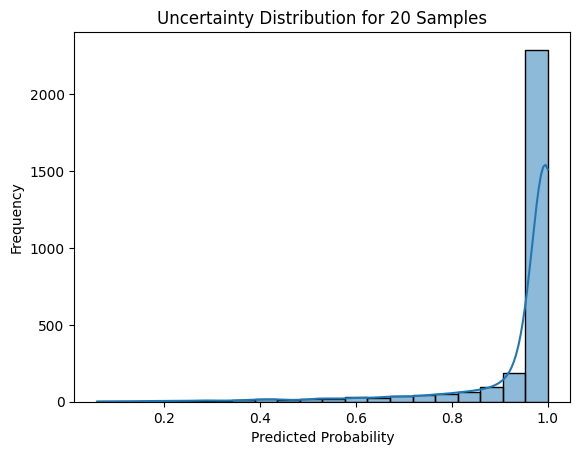

In [229]:
import seaborn as sns
import matplotlib.pyplot as plt
def predict_with_mc_dropout(model, num_samples=20):
    model.train()  # ENABLE dropout
    preds = [torch.sigmoid(model(data.x, data.edge_index)).detach().cpu().numpy() for _ in range(num_samples)]
    predictions = np.array(preds)
    mean_pred = np.mean(predictions, axis=0)
    var_pred = np.var(predictions, axis=0)
    return predictions, mean_pred, var_pred
def plot_uncertainty_distribution(predictions, label="Sample"):
    sns.histplot(predictions, bins=20, kde=True)
    plt.title(f"Uncertainty Distribution for 20 {label}s")
    plt.xlabel("Predicted Probability")
    plt.ylabel("Frequency")
    plt.show()
predictions, _, _ = predict_with_mc_dropout(gnn_model, num_samples=20)
plot_uncertainty_distribution(predictions.flatten())

In [230]:
import warnings
warnings.filterwarnings('ignore') # To ignore all warnings
y_values = np.array(y)  # your target values
variance = np.var(y_values)
scale = np.max(y_values) - np.min(y_values)

print(f"Variance of target y: {variance:.4f}")
print(f"Scale (range) of target y: {scale:.4f}")


Variance of target y: 46.1599
Scale (range) of target y: 44.8028


In [231]:
#y_test_preds = reg_model.predict(X_test)

ml_count, md_count, avg_count  = 0, 0, 0
ml_days, md_days, avg_days  = 0, 0, 0
ml_days_rms, md_days_rms, avg_days_rms  = 0, 0, 0

for i in range(y_test_preds.shape[0]):
    ml_model = abs(y_test_preds[i] - y_test[i])
    
    median_model = abs(actual_median_los - y_test[i])
    average_model = abs(actual_mean_los - y_test[i])
    
    ml_days += ml_model
    md_days += median_model
    avg_days += average_model

    ml_model_rms = (y_test_preds[i] - y_test[i])**2
    median_model_rms = (actual_median_los - y_test[i])**2
    average_model_rms = (actual_mean_los - y_test[i])**2

    ml_days_rms += ml_model_rms
    md_days_rms += median_model_rms
    avg_days_rms += average_model_rms

print("Prediction Model days {}".format(ml_days/y_test_preds.shape[0]))
print("Median Model days {}".format(md_days/y_test_preds.shape[0]))
print("Average Model days {}".format(avg_days/y_test_preds.shape[0]))

print("Prediction Model RMS {}".format((ml_days_rms**0.5)/y_test_preds.shape[0]))
print("Median Model RMS {}".format((md_days_rms**0.5)/y_test_preds.shape[0]))
print("Average Model RMS {}".format((avg_days_rms**0.5)/y_test_preds.shape[0]))

Prediction Model days 5.850264072418213
Median Model days 5.931990623474121
Average Model days 5.635764122009277
Prediction Model RMS 1.5091978311538696
Median Model RMS 1.8179389238357544
Average Model RMS 1.7087539434432983


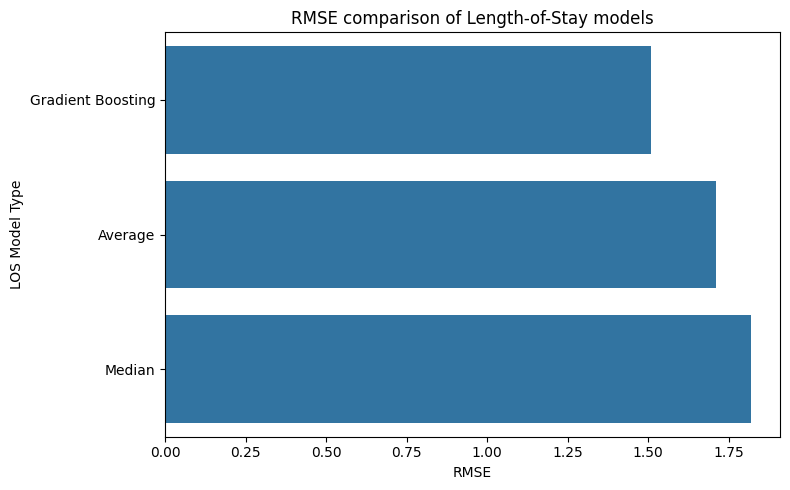

In [232]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Assume these are PyTorch tensors - convert to floats
ml_val = ((ml_days_rms**0.5)/y_test_preds.shape[0]).item() if hasattr(ml_days_rms, 'item') else float(ml_days_rms)
avg_val = ((avg_days_rms**0.5)/y_test_preds.shape[0]).item() if hasattr(avg_days_rms, 'item') else float(avg_days_rms)
md_val = ((md_days_rms**0.5)/y_test_preds.shape[0]).item() if hasattr(md_days_rms, 'item') else float(md_days_rms)

data = pd.DataFrame({
    'RMSE': [ml_val, avg_val, md_val],
    'LOS Model Type': ['Gradient Boosting', 'Average', 'Median']
})

plt.figure(figsize=(8,5))
sns.barplot(x='RMSE', y='LOS Model Type', data=data)  # No palette, no hue
plt.xlabel('RMSE')
plt.ylabel('LOS Model Type')
plt.title('RMSE comparison of Length-of-Stay models')
plt.tight_layout()
plt.show()

# GNN model Training Conclusion

We can see that the gnn based method has caused improvement over gradient boosting model. Though, this improvement is not considering. So, using similary graphs for node features as patient features do not reflect the patient features structurally through the GNNs. 
Due to the ommited samples and small dataset with only 100 patients, we can not generalize our findings and emtrics through the whole MIMIC dataset. ُince the Full dataset is not publically available and needs subscription to another site to download it. The results do not accurately reflect the model's ability to describe the data and the model needs to be trained on a larger dataset. Therefore, the trained model is only trained on the data to test the method of selecting hyperparameters and layers, and to have a model that can generalize, more data is needed. 